In [711]:
import torch as th
from torch import Tensor, LongTensor
from torch.utils.data import DataLoader
import numpy as np
from copy import deepcopy
import numbers
from datetime import datetime
# Multi-threading
import threading
# Plotting
from IPython import display
import matplotlib.pyplot as plt
import pylab as pl
# Reinforcement learning
import gym
import cv2
import pickle

In [712]:
def default_params():
    """ These are the default parameters used int eh framework. """
    return {  # Debugging outputs and plotting during training
        'plot_frequency': 10,  # plots a debug message avery n steps
        'plot_train_samples': True,  # whether the x-axis is env.steps (True) or episodes (False)
        'print_when_plot': True,  # prints debug message if True
        'print_dots': False,  # prints dots for every gradient update
        # Environment parameters
        'env': 'CartPole-v0',  # the environment the agent is learning in
        'run_steps': 2048,  # samples whole episodes if run_steps <= 0
        'max_episode_length': 200,  # maximum number of steps per episode
        # Runner parameters
        'max_episodes': int(1E6),  # experiment stops after this many episodes
        # 'max_episodes': 1000,         # experiment stops after this many episodes
        'max_steps': int(2E6),  # experiment stops after this many steps
        # 'max_steps': 10000,            # experiment stops after this many steps
        'multi_runner': True,  # uses multiple runners if True
        'parallel_environments': 4,  # number of parallel runners  (only if multi_runner==True)
        # Exploration parameters
        'epsilon_anneal_time': int(2),  # exploration anneals epsilon over these many steps
        'epsilon_finish': 0.1,  # annealing stops at (and keeps) this epsilon
        'epsilon_start': 1,  # annealing starts at this epsilon
        # Optimization parameters
        'lr': 1E-3,  # learning rate of optimizer
        'gamma': 0.99,  # discount factor gamma
        'mini_batch_size': 200,  # number of transitions in a mini-batch
        'batch_size': 500,  # number of transitions in a mini-batch
        'grad_norm_clip': 1,  # gradent clipping if grad norm is larger than this
        # Actor-critic parameters
        'value_loss_param': 0.1,  # governs the relative impact of the value relative to policy loss
        'advantage_bias': True,  # whether the advantages have the value as bias
        'advantage_bootstrap': True,  # whether advantages use bootstrapping (alternatively: returns)
        'offpolicy_iterations': 0,  # how many off-policy iterations are performed
        'value_targets': 'returns',  # either 'returns' or 'td' as regression targets of the value function
        # PPO parameters
        'ppo_clipping': True,  # whether we use the PPO loss
        'ppo_clip_eps': 0.1,  # the epsilon for the PPO loss

        'states_shape': (1,),  # Amount of states
        'num_actions': 5,  # delay between the two stacked observations
    }

In [713]:
class TransitionBatch:
    """ Simple implementation of a batchof transitionsm (or another dictionary-based tensor structure).
        Read and write operations are thread-safe, but the iterator is not (you cannot interate
        over the same TransitionBatch in two threads at the same time). """

    def __init__(self, max_size, transition_format, batch_size=32):
        self.indices = []
        self.size = 0
        self.first = 0
        self.max_size = max_size
        self.batch_size = batch_size
        self.dict = {}
        for key, spec in transition_format.items():
            self.dict[key] = th.zeros([max_size, *spec[0]], dtype=spec[1])

    def _clone_empty_batch(self, max_size=None, batch_size=None):
        """ Clones this TransitionBatch without cloning the data. """
        max_size = self.max_size if max_size is None else max_size
        batch_size = self.batch_size if batch_size is None else batch_size
        return TransitionBatch(max_size=max_size, transition_format={}, batch_size=batch_size)

    def __getitem__(self, key):
        """ Access the TransitionBatch with the [] operator. Use as key either
            - the string name of a variable to get the full tensor of that variable,
            - a slice to get a time-slice over all variables in the batch,
            - a LongTensor that selects a subset of indices for all variables in the batch. """
        # Return the entry of the transition called "key"
        if isinstance(key, str):
            return self.dict[key]
        # Return a slice of the batch
        if isinstance(key, slice):
            key = slice(0 if key.start is None else key.start, self.size if key.stop is None else key.stop,
                        1 if key.step is None else key.step)
            try:
                batch = self._clone_empty_batch()
                batch.size = (key.stop - key.start) // key.step
                for k, v in self.dict.items():
                    batch.dict[k] = v[key]
            finally:
                pass
            return batch
        # Collect and return a set of transitions specified by the LongTensor "key"
        if isinstance(key, th.Tensor):
            try:
                batch = self._clone_empty_batch(max_size=key.shape[0])
                batch.size = key.shape[0]
                for k, v in self.dict.items():
                    key = key.view(batch.size, *[1 for _ in range(len(v.shape[1:]))])
                    batch.dict[k] = v.gather(dim=0, index=key.expand(batch.size, *v.shape[1:]))
            finally:
                pass
            return batch
        return None

    def get_first(self):
        """ Returns a batch of the oldest entries of all variables. """
        batch = self._clone_empty_batch(max_size=1)
        try:
            batch.size = 1
            for k, v in self.dict.items():
                batch.dict[k] = v[self.first].unsqueeze(dim=0)
        finally:
            pass
        return batch

    def get_last(self):
        """ Returns a batch of the newest entries of all variables. """
        batch = self._clone_empty_batch(max_size=1)
        try:
            batch.size = 1
            for k, v in self.dict.items():
                batch.dict[k] = v[(self.first + self.size - 1) % self.size].unsqueeze(dim=0)
        finally:
            pass
        return batch

    def add(self, trans: dict):
        """ Adding transition dictionaries, which can contain Tensors of arbitrary length. """
        if isinstance(trans, TransitionBatch):
            trans = trans.dict
        try:
            n = 0
            idx = None
            for k, v in trans.items():
                if idx is None:
                    n = v.shape[0]
                    idx = th.LongTensor([(self.first + self.size + i) % self.max_size for i in range(n)])
                else:
                    assert n == v.shape[0], 'all tensors in a transition need to have the same batch_size'
                idx = idx.view(idx.shape[0], *[1 for _ in range(len(v.shape) - 1)])
                self.dict[k].scatter_(dim=0, index=idx.expand_as(v), src=v)
            # Increase the size (and handle overflow)
            self.size += n
            if self.size > self.max_size:
                self.first = (self.first + n) % self.max_size
                self.size = self.max_size
        finally:
            pass
        return self

    def trim(self):
        """ Reduces the length of the max_size to its actual size (in-place). Returns self. """
        try:
            for k, v in self.dict.items():
                self.dict[k] = v[:self.size]
            self.max_size = self.size
        finally:
            pass
        return self

    def replace(self, batch, index=0):
        """ Replaces parts of this batch with another batch (which must be smaller). """
        try:
            # assert batch.max_size <= self.max_size - index, "Replacement is larger then target area in batch."
            assert batch.size <= self.max_size - index, "Replacement is larger then target area in batch."
            for k, v in batch.dict.items():
                if batch.size < batch.max_size:
                    v = v[:batch.size]
                self.dict[k][index:(index + batch.max_size)] = v
        finally:
            pass

    def sample(self, batch_size=0):
        """ Samples a random mini-batch from the batch. """
        if batch_size==0:
            batch_size = self.batch_size
        return self[th.randint(high=self.size, size=(batch_size, 1))]

    def __len__(self):
        """ Returns the length of the batch. """
        return self.size

    def __iter__(self):
        """ Initializes an iterator over the batch. """
        self.indices = list(range(self.size))
        np.random.shuffle(self.indices)
        return self

    def __next__(self):
        """ Iterates through batch, returns list of contiguous tensors. """
        if len(self.indices) == 0: raise StopIteration
        size = min(self.batch_size, len(self.indices))
        batch = self[th.LongTensor(self.indices[-size:])]
        self.indices = self.indices[:-size]
        return batch

In [714]:
class Runner:
    """ Implements a simple single-thread runner class. """

    def __init__(self, controller, params={}, exploration_step=1):
        self.env = gym.make(params.get('env', 'CartPole-v0'))
        self.cont_actions = isinstance(self.env.action_space, gym.spaces.Box)
        self.controller = controller
        self.epi_len = params.get('max_episode_length', self.env._max_episode_steps)
        self.gamma = params.get('gamma', 0.99)
        self.use_pixels = params.get('pixel_observations', False)
        if self.use_pixels:
            self.grayscale = params.get('pixel_grayscale', True)
            self.add_last_obs = params.get('pixel_add_last_obs', False)
            self.last_obs_delay = params.get('pixel_last_obs_delay', 4)
            n_colors = 1 if self.grayscale else 3
            n_feats = n_colors * (2 if self.add_last_obs else 1)
            resolution = params.get('pixel_resolution', (25, 25))
            self.state_shape = (n_feats, *resolution)
            self.last_observations = TransitionBatch(max_size=self.last_obs_delay,
                                                     transition_format={'img': ((n_colors, *resolution), th.float32)})
        else:
            self.state_shape = self.env.observation_space.shape
        # Set up current state and time step
        self.sum_rewards = 0
        self.state = None
        self.time = 0
        self._next_step()

    def close(self):
        """ Closes the underlying environment. Should always when ending an experiment. """
        self.env.close()

    def transition_format(self):
        """ Returns the format of transtions: a dictionary of (shape, dtype) entries for each key. """
        return {'actions': ((1,), th.long),
                'states': (self.state_shape, th.float32),
                'next_states': (self.state_shape, th.float32),
                'rewards': ((1,), th.float32),
                'dones': ((1,), th.bool),
                'returns': ((1,), th.float32)}

    def _wrap_transition(self, s, a, r, ns, d):
        """ Takes a transition and returns a corresponding dictionary. """
        trans = {}
        form = self.transition_format()
        for key, val in [('states', s), ('actions', a), ('rewards', r), ('next_states', ns), ('dones', d)]:
            if not isinstance(val, th.Tensor):
                if isinstance(val, numbers.Number) or isinstance(val, bool): val = [val]
                val = th.tensor(val, dtype=form[key][1])
            if len(val.shape) < len(form[key][0]) + 1: val = val.unsqueeze(dim=0)
            trans[key] = val
        return trans

    def _pixel_observation(self, reset=False):
        """ Returns the pixel-observation fo the current state. Opens extra window for rendering. """
        img = self.env.render(mode='rgb_array')
        img = cv2.resize(img, dsize=self.state_shape[1:], interpolation=cv2.INTER_CUBIC)
        img = th.from_numpy(img.astype(np.float32) / 255).transpose(dim0=0, dim1=2).unsqueeze(dim=0)
        if self.grayscale: img = img.mean(dim=1, keepdim=True)
        if self.add_last_obs:
            if reset: self.last_observations.size = 0
            if self.last_observations.size < self.last_observations.max_size:
                obs = img * 0
            else:
                obs = self.last_observations.get_first()['img'].clone()
            self.last_observations.add({'img': img})
            img = th.cat([obs, img], dim=1)
        return img

    def _run_step(self, a):
        """ Make a step in the environment (and update internal bookeeping) """
        ns, r, d, _ = self.env.step(a.item())
        self.sum_rewards += r
        if self.use_pixels: ns = self._pixel_observation()
        return r, ns, d

    def _next_step(self, done=True, next_state=None):
        """ Switch to the next time-step (and update internal bookeeping) """
        self.time = 0 if done else self.time + 1
        if done:
            self.sum_rewards = 0
            self.state = self.env.reset()
            if self.use_pixels: self.state = self._pixel_observation(reset=True)
        else:
            self.state = next_state

    def run(self, n_steps, transition_buffer=None, trim=True, return_dict=None):
        """ Runs n_steps in the environment and stores them in the trainsition_buffer (newly created if None).
            If n_steps <= 0, stops at the end of an episode and optionally trins the transition_buffer.
            Returns a dictionary containing the transition_buffer and episode statstics. """
        my_transition_buffer = TransitionBatch(n_steps if n_steps > 0 else self.epi_len, self.transition_format())
        time, episode_start, episode_lengths, episode_rewards = 0, 0, [], []
        max_steps = n_steps if n_steps > 0 else self.epi_len
        for t in range(max_steps):
            # One step in the envionment
            a = self.controller.choose(self.state)
            r, ns, d = self._run_step(a)
            terminal = d and self.time < self.epi_len - 1
            my_transition_buffer.add(self._wrap_transition(self.state, a, r, ns, terminal))
            if t == self.epi_len - 1: d = True
            # Compute discounted returns if episode has ended or max_steps has been reached
            if d or t == (max_steps - 1):
                my_transition_buffer['returns'][t] = my_transition_buffer['rewards'][t]
                for i in range(t - 1, episode_start - 1, -1):
                    my_transition_buffer['returns'][i] = my_transition_buffer['rewards'][i] \
                                                         + self.gamma * my_transition_buffer['returns'][i + 1]
                episode_start = t + 1
            # Remember statistics and advance (potentially initilaizing a new episode)
            if d:
                episode_lengths.append(self.time + 1)
                episode_rewards.append(self.sum_rewards)
            self._next_step(done=d, next_state=ns)
            time += 1
            # If n_steps <= 0, we return after one episode (trimmed if specified)
            if d and n_steps <= 0:
                my_transition_buffer.trim()
                break
        # Add the sampled transitions to the given transition buffer
        transition_buffer = my_transition_buffer if transition_buffer is None \
            else transition_buffer.add(my_transition_buffer)
        if trim: transition_buffer.trim()
        # Return statistics (mean reward, mean length and environment steps)
        if return_dict is None: return_dict = {}
        return_dict.update({'buffer': transition_buffer,
                            'episode_reward': None if len(episode_rewards) == 0 else np.mean(episode_rewards),
                            'episode_length': None if len(episode_lengths) == 0 else np.mean(episode_lengths),
                            'env_steps': time})
        return return_dict

    def run_episode(self, transition_buffer=None, trim=True, return_dict=None):
        """ Runs one episode in the environemnt.
            Returns a dictionary containing the transition_buffer and episode statstics. """
        return self.run(0, transition_buffer, trim, return_dict)

In [715]:
class QController:
    """ Controller for Q-value functions, synchronizes the model calls. """

    def __init__(self, model, num_actions=None, params={}):
        self.lock = threading.Lock()
        self.num_actions = model[-1].out_features if num_actions is None else num_actions

        self.model =model
        self.model_actor = model[0]
        self.model_critic = model[1]

    def copy(self):
        """ Shallow copy of this controller that does not copy the model. """
        return QController(model=self.model, num_actions=self.num_actions)

    def parameters(self):
        """ Returns a generator of the underlying model parameters. """

        return self.model[0].parameters(), self.model[1].parameters(), self.model[2].parameters()

    def sanitize_inputs(self, observation, **kwargs):
        """ Casts numpy arrays as Tensors. """
        if isinstance(observation, np.ndarray):
            observation = th.Tensor(observation).unsqueeze(dim=0)
        return observation

    def choose(self, observation, **kwargs):
        """ Returns the greedy actions the agent would choose when facing an "observation". """
        self.lock.acquire()
        try:
            mx = self.model[0](self.sanitize_inputs(observation))
            if mx.shape[-1] > self.num_actions: mx = mx[:, :self.num_actions]
        finally:
            self.lock.release()
        return th.max(mx, dim=-1)[1]

    def probabilities(self, observation, **kwargs):
        """ Returns the probabilities with which the agent would choose actions (here one-hot because greedy). """
        self.lock.acquire()
        try:
            mx = self.model[0](self.sanitize_inputs(observation))
            if mx.shape[-1] > self.num_actions: mx = mx[:, :self.num_actions]
        finally:
            self.lock.release()
        return th.zeros(*mx.shape).scatter_(dim=-1, index=th.max(mx, dim=-1)[1].unsqueeze(dim=-1), src=th.ones(1, 1))

In [716]:
class ACController(QController):
    """ A controller that interprets the first num_actions model outputs as logits of a softmax distribution. """

    def probabilities(self, observation, precomputed=False, **kwargs):
        self.lock.acquire()
        try:
            mx = observation if precomputed else self.model[0](self.sanitize_inputs(observation))[:, :self.num_actions]
        finally:
            self.lock.release()
        return th.nn.functional.softmax(mx, dim=-1)

    def choose(self, observation, **kwargs):
        return th.distributions.Categorical(probs=self.probabilities(observation, **kwargs)).sample()

In [717]:
class EpsilonGreedyController:
    """ A wrapper that makes any controller into an epsilon-greedy controller.
        Keeps track of training-steps to decay exploration automatically. """

    def __init__(self, controller, params={}, exploration_step=1):
        self.controller = controller
        self.num_actions = controller.num_actions
        self.max_eps = params.get('epsilon_start', 1.0)
        self.min_eps = params.get('epsilon_finish', 0.05)
        self.anneal_time = int(params.get('epsilon_anneal_time', 10000) / exploration_step)
        self.num_decisions = 0

    def epsilon(self):
        """ Returns current epsilon. """
        return max(1 - self.num_decisions / (self.anneal_time - 1), 0) \
               * (self.max_eps - self.min_eps) + self.min_eps

    def choose(self, observation, increase_counter=True, **kwargs):
        """ Returns the (possibly random) actions the agent takes when faced with "observation".
            Decays epsilon only when increase_counter=True". """
        eps = self.epsilon()
        if increase_counter: self.num_decisions += 1
        if np.random.rand() < eps:
            return th.randint(self.controller.num_actions, (1,), dtype=th.long)
        else:
            return self.controller.choose(observation, **kwargs)

    def probabilities(self, observation, **kwargs):
        """ Returns the probabilities with which the agent would choose actions. """
        eps = self.epsilon()
        return eps * th.ones(1, 1) / self.num_actions + \
               (1 - eps) * self.controller.probabilities(observation, **kwargs)

In [718]:
class BatchReinforceLearner:
    """ A learner that performs a version of REINFORCE. """

    def __init__(self, model, controller=None, params={}):
        self.learner = None
        self.model_actor = model[0]
        self.model_critic = model[1]
        self.model_w = model[2]

        self.controller = controller
        self.value_loss_param = params.get('value_loss_param', 1)
        self.offpolicy_iterations = params.get('offpolicy_iterations', 10)

        self.all_parameters_actor = list(model_actor.parameters())
        self.optimizer_actor = th.optim.Adam(self.all_parameters_actor, lr=params.get('lr', 1E-3))

        self.all_parameters_critic = list(model_critic.parameters())
        self.optimizer_critic = th.optim.Adam(self.all_parameters_critic, lr=params.get('lr', 1E-3))

        self.gamma = params.get('gamma')

        self.grad_norm_clip = params.get('grad_norm_clip', 10)
        self.compute_next_val = False  # whether the next state's value is computed
        self.opposd = params.get('opposd', False)
        self.num_actions = params.get('num_actions', 5)
        self.old_pi = th.ones(1, 1) / self.num_actions
        self.pi_0 = None

    def set_controller(self, controller):
        """ This function is called in the experiment to set the controller. """
        self.controller = controller

    def _advantages(self, batch, values=None, next_values=None):
        """ Computes the advantages, Q-values or returns for the policy loss. """
        return batch['returns']

    def _value_loss(self, batch, values=None, next_values=None):
        """ Computes the value loss (if there is one). """
        return 0

    def _policy_loss(self, pi, advantages):
        """ Computes the policy loss. """
        return -(advantages.detach() * pi.log()).mean()

    def update_policy_distribution(self, batch, ratios):
        pass

    def train(self, batch):
        assert self.controller is not None, "Before train() is called, a controller must be specified. "

        # model = [model_actor, model_critic, model_w]
        loss_sum = 0.0
        for _ in range(1 + self.offpolicy_iterations):
# HERE START
            if self.opposd:
                for _ in range(50):
                    # batch_w = self.runner.run(self.batch_size, transition_buffer)
                    batch_w = batch.sample(200)
                    self.pi_0 = self.old_pi + 0 * batch_w['returns']
                    # Compute the model-output for given batch
                    pi = th.nn.functional.softmax(self.model_actor(batch_w['states']), dim=-1).gather(dim=-1, index=batch_w['actions'])
                    self.update_policy_distribution(batch_w, pi.detach()/self.pi_0)

            for _ in range(10):
                batch_c = batch.sample(int(5e3))

                val = self.model_critic(batch_c['states'])
                next_val = self.model_critic(batch_c['next_states'])
                pi = th.nn.functional.softmax(self.model_actor(batch_c['states']), dim=-1).gather(dim=-1, index=batch_c['actions'])
                pi.detach()
                self.pi_0 = self.old_pi + 0 * batch_c['returns']

                # value_loss = self._value_loss(batch_c, val, next_val)

                targets = batch_c['returns']

                # loss_fn = th.nn.MSELoss()
                # value_loss = loss_fn(val, targets)

                value_loss = th.mean((pi/self.pi_0) * (targets - val)**2)

                self.optimizer_critic.zero_grad()
                value_loss.backward()
                th.nn.utils.clip_grad_norm_(self.all_parameters_critic, self.grad_norm_clip)
                self.optimizer_critic.step()

            batch_a = batch.sample(int(5e3))

            pi = th.nn.functional.softmax(self.model_actor(batch_a['states']), dim=-1).gather(dim=-1, index=batch_a['actions'])

            val = self.model_critic(batch_a['states'])
            next_val = self.model_critic(batch_a['next_states'])
            self.pi_0 = self.old_pi + 0 * batch_a['returns']

            Q = self._advantages(batch_a, val, next_val)
            ratios = pi / self.pi_0.detach()
            if self.opposd:
                w = self.model_w(batch_a['states']).detach()
                w /= th.mean(w)
                ratios = w * ratios
            policy_loss = -(Q.detach() * ratios).mean()

            self.optimizer_actor.zero_grad()
            policy_loss.backward()
            th.nn.utils.clip_grad_norm_(self.all_parameters_actor, self.grad_norm_clip)
            self.optimizer_actor.step()

            # Combine policy and value loss
            loss = policy_loss.detach().item()

            loss_sum += loss
        return loss_sum

In [719]:
class Experiment:
    """ Abstract class of an experiment. Contains logging and plotting functionality."""

    def __init__(self, params, model, **kwargs):
        self.params = params
        self.plot_frequency = params.get('plot_frequency', 10)
        self.plot_train_samples = params.get('plot_train_samples', True)
        self.print_when_plot = params.get('print_when_plot', False)
        self.print_dots = params.get('print_dots', False)
        self.episode_returns = []
        self.episode_lengths = []
        self.episode_losses = []
        self.env_steps = []
        self.total_run_time = 0.0

    def plot_training(self, update=False):
        """ Plots logged training results. Use "update=True" if the plot is continuously updated
            or use "update=False" if this is the final call (otherwise there will be double plotting). """
        # Smooth curves
        window = max(int(len(self.episode_returns) / 3), 1)
        returns = np.convolve(self.episode_returns, np.ones(window) / window, 'valid')
        # Determine x-axis based on samples or episodes
        x_returns = [(i + window) for i in range(len(returns))]
        # Create plot
        colors = ['b', 'g', 'r']
        # fig.set_size_inches(16, 4)
        plt.clf()
        # Plot the losses in the left subplot
        # pl.subplot(1, 3, 1)
        plt.plot(x_returns, returns, colors[0])
        plt.xlabel('Environment steps' if self.plot_train_samples else 'Policy gradient steps')
        plt.ylabel('Episode return')
        display.clear_output(wait=True)
        if update:
            display.display(pl.gcf())

    def close(self):
        """ Frees all allocated runtime ressources, but allows to continue the experiment later.
            Calling the run() method after close must be able to pick up the experiment where it was. """
        pass

    def run(self):
        """ Starts (or continues) the experiment. """
        assert False, "You need to extend the Expeirment class and override the method run(). "

In [720]:
class BatchActorCriticExperiment(Experiment):
    def __init__(self, params, model, learner=None, **kwargs):
        super().__init__(params, model, **kwargs)
        self.models = model
        self.max_episodes = params.get('max_episodes', int(1E6))
        self.max_batch_episodes = params.get('max_batch_episodes', int(1E6))
        self.max_steps = params.get('max_steps', int(1E9))
        self.grad_repeats = params.get('grad_repeats', 1)
        self.batch_size = params.get('batch_size', 1e5)
        self.mini_batch_size = params.get('mini_batch_size', 200)
        self.controller = ACController(model, num_actions=gym.make(params['env']).action_space.n, params=params)
        # self.controller = EpsilonGreedyController(controller=self.controller, params=params)
        self.runner = Runner(self.controller, params=params)
        self.learner = BatchReinforceLearner(model, params=params) if learner is None else learner
        self.learner.set_controller(self.controller)
        self.opposd = params.get('opposd', False)
        self.opposd_iterations = params.get('opposd_iterations', 50)

    def get_transition_batch(self):
        transition_buffer = TransitionBatch(self.batch_size, self.runner.transition_format(), self.mini_batch_size)
        batch = self.runner.run(self.batch_size, transition_buffer)
        return batch

    def close(self):
        """ Overrides Experiment.close() """
        self.runner.close()

    def run(self, batch=None):
        """ Overrides Experiment.run() """
        # Plot past results if available
        if self.plot_frequency is not None and len(self.episode_losses) > 2:
            self.plot_training(update=True)
        # Run the experiment
        if not batch:
            batch = self.get_transition_batch()
        for e in range(self.max_batch_episodes):
            # Make a gradient update step
            self.learner.train(batch['buffer'])

            for _ in range(10):
                partial_result = self.runner.run_episode()
                if partial_result['episode_length'] is not None:
                    self.episode_lengths.append(partial_result['episode_length'])
                    self.episode_returns.append(partial_result['episode_reward'])

            if self.plot_frequency is not None and (e + 1) % self.plot_frequency == 0:
                self.plot_training(update=True)
                if self.print_when_plot:
                    print('Batch %u, epi-return %.4g +- %.3g, length %u' %
                          (len(self.episode_returns), np.mean(self.episode_returns[-10:]),
                           np.std(self.episode_returns[-10:]), np.mean(self.episode_lengths[-10:])))

In [721]:
class BiasedReinforceLearner(BatchReinforceLearner):
    def __init__(self, model, controller=None, params={}):
        super().__init__(model=model, controller=controller, params=params)
        self.value_criterion = th.nn.MSELoss()
        self.advantage_bias = params.get('advantage_bias', True)
        self.value_targets = params.get('value_targets', 'returns')
        self.gamma = params.get('gamma')
        self.compute_next_val = (self.value_targets == 'td')

    def _advantages(self, batch, values=None, next_values=None):
        """ Computes the advantages, Q-values or returns for the policy loss. """
        advantages = batch['returns']
        if self.advantage_bias:
            advantages -= values
        return advantages

    def _value_loss(self, batch, values=None, next_values=None):
        """ Computes the value loss (if there is one). """
        targets = None
        if self.value_targets == 'returns':
            targets = batch['returns']
        elif self.value_targets == 'td':
            targets = batch['rewards'] + self.gamma * (~batch['dones'] * next_values)
        return self.value_criterion(values, targets.detach())

In [722]:
class ActorCriticLearner(BiasedReinforceLearner):
    def __init__(self, model, controller=None, params={}):
        super().__init__(model=model, controller=controller, params=params)
        self.advantage_bootstrap = params.get('advantage_bootstrap', True)
        self.compute_next_val = self.compute_next_val or self.advantage_bootstrap

    def _advantages(self, batch, values=None, next_values=None):
        """ Computes the advantages, Q-values or returns for the policy loss. """
        advantages = None
        if self.advantage_bootstrap:
            advantages = batch['rewards'] + self.gamma * (~batch['dones'] * next_values)
        else:
            advantages = batch['returns']
        if self.advantage_bias:
            advantages = advantages - values
        return advantages

In [723]:
class OffpolicyActorCriticLearner(ActorCriticLearner):
    def __init__(self, model, controller=None, params={}):
        super().__init__(model=model, controller=controller, params=params)

    def _policy_loss(self, pi, advantages):
        """ Computes the policy loss. """
        if self.old_pi is None:
            self.old_pi = pi  # remember on-policy probabilities for off-policy losses
            # Return the defaul on-policy loss
            return super()._policy_loss(pi, advantages)
        else:
            # The loss for off-policy data
            ratios = pi / self.pi_0.detach()
            return -(advantages.detach() * ratios).mean()

In [724]:
class PPOLearner(OffpolicyActorCriticLearner):
    def __init__(self, model, controller=None, params={}):
        super().__init__(model=model, controller=controller, params=params)
        self.ppo_clipping = params.get('ppo_clipping', False)
        self.ppo_clip_eps = params.get('ppo_clip_eps', 0.2)

    def _policy_loss(self, pi, advantages):
        """ Computes the policy loss. """
        if self.old_pi is None:
            # The loss for on-policy data does not change
            return super()._policy_loss(pi, advantages)
        else:
            # The loss for off-policy data
            ratios = pi / self.pi_0.detach()
            loss = advantages.detach() * ratios
            if self.ppo_clipping:
                # off-policy loss with PPO clipping
                ppo_loss = th.clamp(ratios, 1 - self.ppo_clip_eps, 1 + self.ppo_clip_eps) * advantages.detach()
                loss = th.min(loss, ppo_loss)
            return -loss.mean()

In [725]:
class OPPOSDLearner(OffpolicyActorCriticLearner):
    def __init__(self, model, controller=None, params={}):
        super().__init__(model=model, controller=controller, params=params)
        self.num_actions = params.get('num_actions', 5)
        self.batch_size = params.get('batch_size')
        self.states_shape = params.get('states_shape')
        self.w_grad_norm_clip = params.get('grad_norm_clip', 10)
        self.parameters_w = list(self.model_w.parameters())
        self.optimizer_w = th.optim.Adam(self.parameters_w, lr=1E-3)

    def _policy_loss(self, pi, advantages):
        # The loss for off-policy data
        loss = advantages.detach() * pi
        return -loss.mean()

    def reset_w_net(self):
        pass
        # self.w_model = th.nn.Sequential(th.nn.Linear(self.states_shape, 128), th.nn.ReLU(),
        #                                 th.nn.Linear(128, 512), th.nn.ReLU(),
        #                                 th.nn.Linear(512, 128), th.nn.ReLU(),
        #                                 th.nn.Linear(128, 1))
        # self.w_parameters = list(self.w_model.parameters())
        # self.w_optimizer = th.optim.Adam(self.w_parameters, lr=params.get('lr', 5E-4))

    def update_policy_distribution(self, batch, ratios):
        self.model_w.train(True)
        batch_size = batch.size

        next_states = batch['next_states']
        with th.autograd.set_detect_anomaly(True):
            w = self.model_w(batch['states'])
            w_ = self.model_w(batch['next_states'])

            w = w / th.mean(w)
            w_ = w_ / th.mean(w_)

            d = w * ratios - w_

            k = th.zeros(batch_size, batch_size, self.states_shape)
            for i in range(self.states_shape):
                k[:, :, i] = next_states[:, i].view(1, -1) - next_states[:, i].view(-1, 1)

            k = th.exp(-th.linalg.norm(k, dim=-1)/2)
            prod = th.matmul(d, d.transpose(0, 1))

            # n_lm = 3
            # y = th.randn(n_lm, 4)
            # dist_gt = th.zeros(n_lm, n_lm, 4)
            # dist_gt[:,:,0] = y[:,0].view(1,-1) - y[:,0].view(-1,1)
            # dist_gt[:,:,1] = y[:,1].view(1,-1) - y[:,1].view(-1,1)
            # dist_gt[:,:,2] = y[:,2].view(1,-1) - y[:,2].view(-1,1)
            # dist_gt[:,:,3] = y[:,3].view(1,-1) - y[:,3].view(-1,1)
            # th.linalg.norm(dist_gt, dim=-1)
            # k = (th.linalg.norm(dist_gt, dim=-1)<1).float()

            D = th.sum(prod * k) / batch_size

            self.optimizer_w.zero_grad()
            D.backward()
            th.nn.utils.clip_grad_norm_(self.parameters_w, self.w_grad_norm_clip)
            self.optimizer_w.step()

In [726]:
experiments = []

In [27]:
params = default_params()
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]
params['states_shape'] = state_dim
params['num_actions'] = n_actions
params['batch_size'] = int(1e5)
params['mini_batch_size'] = 200

# The model has n_action policy heads and one value head
# model_actor = th.nn.Sequential(th.nn.Linear(state_dim, 32), th.nn.ReLU(),
#                          th.nn.Linear(32, n_actions))
model_actor = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 512), th.nn.ReLU(),
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions + 1))
model_critic = th.nn.Sequential(th.nn.Linear(state_dim, 32), th.nn.ReLU(),
                         th.nn.Linear(32, 1))
model_w = th.nn.Sequential(th.nn.Linear(state_dim, 32), th.nn.ReLU(),
                         th.nn.Linear(32, 1), th.nn.Softplus())
model = [model_actor, model_critic, model_w]
# experiment = BatchActorCriticExperiment(params, model, learner=OPPOSDLearner(model, params=params))
# experiments_batch = experiment.get_transition_batch()
# dbfile = open('cartpolePickle', 'ab')
# pickle.dump(experiments_batch, dbfile)
# dbfile.close()

dbfile = open('cartpolePickle', 'rb')
experiments_batch = pickle.load(dbfile)
dbfile.close()
heuristic = True



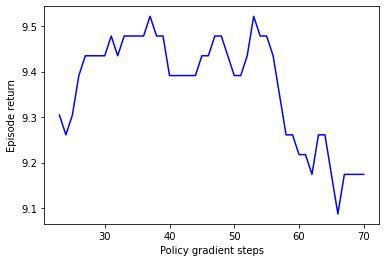

In [30]:
return_dict = {}
params = default_params()
params['offpolicy_iterations'] = 10
params['plot_train_samples'] = False
params['plot_frequency'] = 4
params['max_batch_episodes'] = int(200)
params['batch_size'] = int(1e5)
params['mini_batch_size'] = 200
params['opposd'] = True
params['opposd_iterations'] = 50
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]
params['states_shape'] = state_dim
params['num_actions'] = n_actions

experiment = BatchActorCriticExperiment(params, model, learner=OPPOSDLearner(model, params=params))
try:
    experiment.run(experiments_batch)
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()

return_dict.update({'model' : 'OPPOSD',
                            'experiment': experiment})
experiments = np.append(experiments, return_dict)

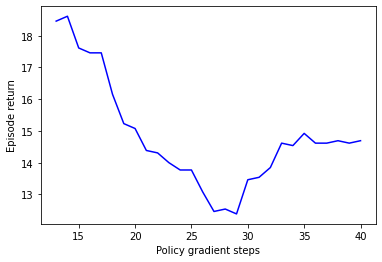

Batch 40, epi-return 14 +- 3.71, length 14


In [ ]:
return_dict = {}
params = default_params()
params['offpolicy_iterations'] = 10
params['plot_train_samples'] = False
params['plot_frequency'] = 4
params['max_batch_episodes'] = int(50)
params['batch_size'] = int(1e5)
params['mini_batch_size'] = 1000
params['opposd'] = True
params['opposd_iterations'] = 50
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]
params['states_shape'] = state_dim
params['num_actions'] = n_actions

# The model has n_action policy heads and one value head
model_actor = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions))
model_critic = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 1))
# model_w = th.nn.Sequential(th.nn.Linear(state_dim, 32), th.nn.ReLU(),
#                          th.nn.Linear(32, 1), th.nn.Softplus())
model_w = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 1), th.nn.Softplus())
model = [model_actor, model_critic, model_w]
experiment = BatchActorCriticExperiment(params, model, learner=OPPOSDLearner(model, params=params))
try:
    experiment.run(experiments_batch)
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()

return_dict.update({'model' : 'OPPOSD',
                            'experiment': experiment})
experiments = np.append(experiments, return_dict)

In [ ]:
return_dict = {}
params = default_params()
params['offpolicy_iterations'] = 10
params['plot_train_samples'] = False
params['plot_frequency'] = 4
params['max_batch_episodes'] = int(50)
params['batch_size'] = int(1e5)
params['mini_batch_size'] = 1000
params['opposd'] = False
params['opposd_iterations'] = 50
env = gym.make(params['env'])
n_actions, state_dim = env.action_space.n, env.observation_space.shape[0]
params['states_shape'] = state_dim
params['num_actions'] = n_actions

# The model has n_action policy heads and one value head
model_actor = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions))
model_critic = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 1))
model_w = th.nn.Sequential(th.nn.Linear(state_dim, 32), th.nn.ReLU(),
                         th.nn.Linear(32, 1), th.nn.Softplus())
model = [model_actor, model_critic, model_w]
experiment = BatchActorCriticExperiment(params, model, learner=OffpolicyActorCriticLearner(model, params=params))
try:
    experiment.run(experiments_batch)
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()

return_dict.update({'model' : 'OFFPAC',
                            'experiment': experiment})
experiments = np.append(experiments, return_dict)

In [217]:
def plot_experiments(experiments):
    # sns.set()
    colors = ['r', 'b', 'g', 'k']
    plt.figure(figsize=(8, 6), dpi=80)
    i = 0
    for exp in [experiments[0],experiments[2], experiments[1]]:
        # Smooth curves
        window = max(int(len(exp['experiment'].episode_returns) / 30), 1)
        # if len(exp.episode_losses) < window + 2: return
        returns = np.convolve(exp['experiment'].episode_returns, np.ones(window) / window, 'valid')
        # Determine x-axis based on samples or episodes
        x_returns = [i + window for i in range(len(returns))]
        plt.plot(x_returns, returns, colors[i], label=exp['model'])
        plt.xlabel('Policy gradient step')
        plt.ylabel('Episode return')
        i+=1
    plt.legend()
    plt.title('Cart pole environment')
    plt.savefig('cartpole_comp.pdf')

In [ ]:
plot_experiments(experiments)

In [198]:
experiments[1]

{'model': 'PPO',
 'experiment': <__main__.BatchActorCriticExperiment at 0x7fa10ed454c0>}